# Plot interval holding fraction of energy, as box plot

In [2]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker
import mplhep as hep
plt.style.use(hep.style.CMS)
import hist

sys.path.append("../../..")
from HistogramLib.histogram import HistogramKind
from HistogramLib.store import HistogramStore
from hists.parameters import beamEnergies
from hists.store import HistogramId
from hists.dataframe import DataframeComputations

In [17]:
hist_folder = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v32'
#clueParams = "single-file"
clueParams = "cmssw"
histStore = HistogramStore(hist_folder, HistogramId)
datatypeToLegendMap = {"data":"Data", "sim_proton_v46_patchMIP":"Simulation"}

In [4]:
h = (histStore
        .get(HistogramId("Clus3DIntervalHoldingFractionOfEnergy", clueParams, "data"))
        .getHistogram(HistogramKind.PROFILE)
    [{
        "mainOrAllTracksters" : hist.loc("mainTrackster"),
        # Project on clus3D_size
        "maskLayer" : hist.loc("no"),
        "beamEnergy" : hist.loc(20)
    }]
    .project("intervalFractionEnergy_minLayer", "intervalFractionEnergy_maxLayer")
)
h

Hist(
  Integer(0, 30, name='intervalFractionEnergy_minLayer', label='Minimum layer of smallest interval holding at least fraction of 3D cluster energy'),
  Integer(0, 30, name='intervalFractionEnergy_maxLayer', label='Maximum layer of smallest interval holding at least fraction of 3D cluster energy'),
  storage=Mean()) # Sum: Mean(count=59394, value=17.5557, variance=5.12975)

## Single datatype

In [5]:
def plotBarSingle(datatype:str, energyFraction:str, beamEnergies:list[int]):
    fig, ax = plt.subplots()

    hists = [histStore
        .get(HistogramId("Clus3DIntervalHoldingFractionOfEnergy", clueParams, "data"))
        .getHistogram(HistogramKind.COUNT)
        [{
            "mainOrAllTracksters" : hist.loc("mainTrackster"),
            # Project on clus3D_size
            "maskLayer" : hist.loc("no"),
            "intervalEnergyFraction" : hist.loc(energyFraction),
            "beamEnergy" : hist.loc(beamEnergy),
        }]
        .project("intervalFractionEnergy_minLayer", "intervalFractionEnergy_maxLayer")
    for beamEnergy in beamEnergies]

    height = 1.
    y_locations = np.linspace(0, height*1.5*len(hists), num=len(hists))
    widths = []
    left_locations = []
    layer_numbers = np.array([hists[0].axes[0].bin(i) for i in range(hists[0].axes[0].size)])
    #return layer_numbers.dtype
    for y_loc, h in zip(y_locations, hists):
        #return h.project("intervalFractionEnergy_minLayer").view(flow=False)
        avg_min = np.average(layer_numbers, weights=h.project("intervalFractionEnergy_minLayer").view(flow=False))
        avg_max = np.average(layer_numbers, weights=h.project("intervalFractionEnergy_maxLayer").view(flow=False))
        left_locations.append(avg_min)
        widths.append(avg_max-avg_min)
    
    ax.barh(y=y_locations, width=widths, height=0.8, left=left_locations)

    ax.set_xlabel("Layer")
    ax.set_ylabel("Beam energy (GeV)")
    ax.set_xlim(left=1)
    #ax.set_ylim(bottom=y_locations[0]-max_height/2*1.3)
    ax.set_yticks(y_locations, beamEnergies)
    ax.yaxis.set_minor_locator(matplotlib.ticker.NullLocator())

    if "data" == datatype:
        hep.cms.text("Preliminary")
    else:
        hep.cms.text("Simulation Preliminary")
    hep.cms.lumitext(f"fraction : {float(energyFraction):.0%} - $e^+$ test beam")

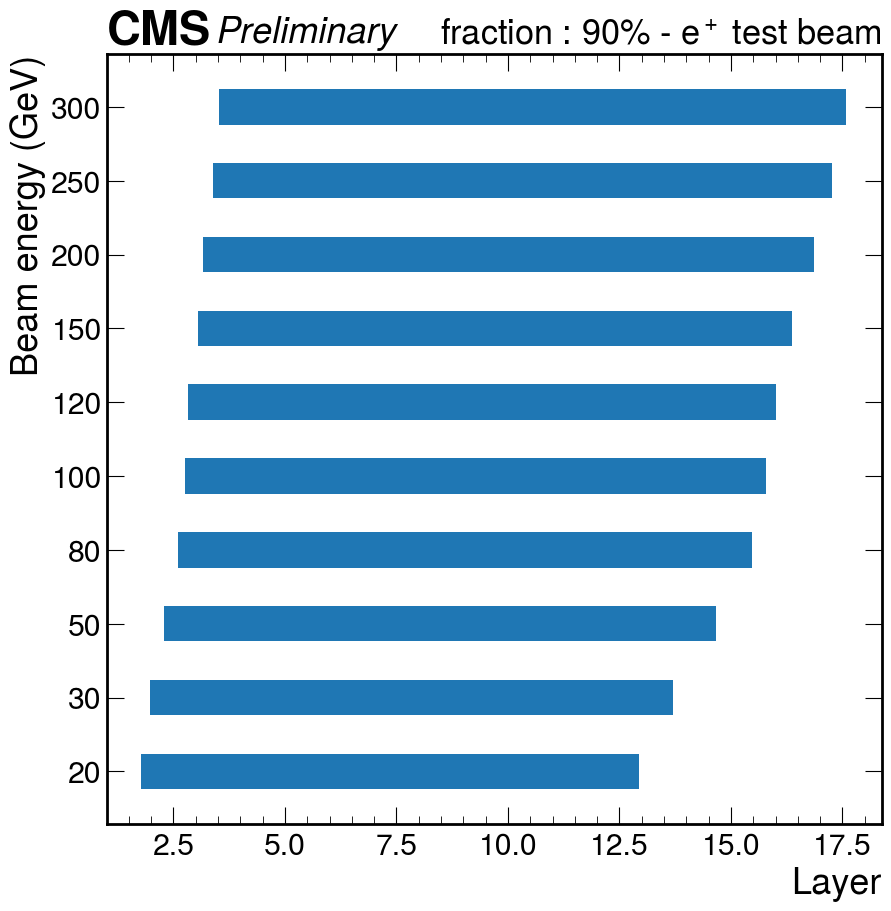

In [6]:
plotBarSingle("data", "0.9", beamEnergies)

## Overlay data/sim

In [22]:
def plotBarDouble(datatypes:str, energyFraction:str, beamEnergies:list[int]):
    fig, ax = plt.subplots()

    hists = [[histStore
        .get(HistogramId("Clus3DIntervalHoldingFractionOfEnergy", clueParams, datatype))
        .getHistogram(HistogramKind.COUNT)
        [{
            "mainOrAllTracksters" : hist.loc("mainTrackster"),
            # Project on clus3D_size
            "maskLayer" : hist.loc("no"),
            "intervalEnergyFraction" : hist.loc(energyFraction),
            "beamEnergy" : hist.loc(beamEnergy),
        }]
        .project("intervalFractionEnergy_minLayer", "intervalFractionEnergy_maxLayer")
        for datatype in datatypes]
    for beamEnergy in beamEnergies]

    singleBarHeight = 1.
    barGroupHeight = len(datatypes)*singleBarHeight + singleBarHeight*1.2
    y_group_locations = np.linspace(0, barGroupHeight*len(beamEnergies), num=len(beamEnergies))
    layer_numbers = np.array([hists[0][0].axes[0].bin(i) for i in range(hists[0][0].axes[0].size)])

    for datatype_i, datatype in enumerate(datatypes):
        widths = []
        left_locations = []
        y_locations = y_group_locations + datatype_i*singleBarHeight

        for hists_list in hists:
            h = hists_list[datatype_i]
            avg_min = np.average(layer_numbers, weights=h.project("intervalFractionEnergy_minLayer").view(flow=False))
            avg_max = np.average(layer_numbers, weights=h.project("intervalFractionEnergy_maxLayer").view(flow=False))
            left_locations.append(avg_min)
            widths.append(avg_max-avg_min)

        ax.barh(y=y_locations, width=widths, height=singleBarHeight, left=left_locations, label=datatypeToLegendMap.get(datatype, datatype))
        

    ax.set_xlabel("Layer")
    ax.set_ylabel("Beam energy (GeV)")
    ax.set_xlim(1, 22)
    ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    #ax.set_ylim(bottom=y_locations[0]-max_height/2*1.3)
    ax.set_yticks(y_locations, beamEnergies)
    ax.yaxis.set_minor_locator(matplotlib.ticker.NullLocator())
    ax.legend()

    if "data" in datatypes:
        hep.cms.text("Preliminary")
    else:
        hep.cms.text("Simulation Preliminary")
    hep.cms.lumitext(f"fraction : {float(energyFraction):.0%} - $e^+$ test beam")

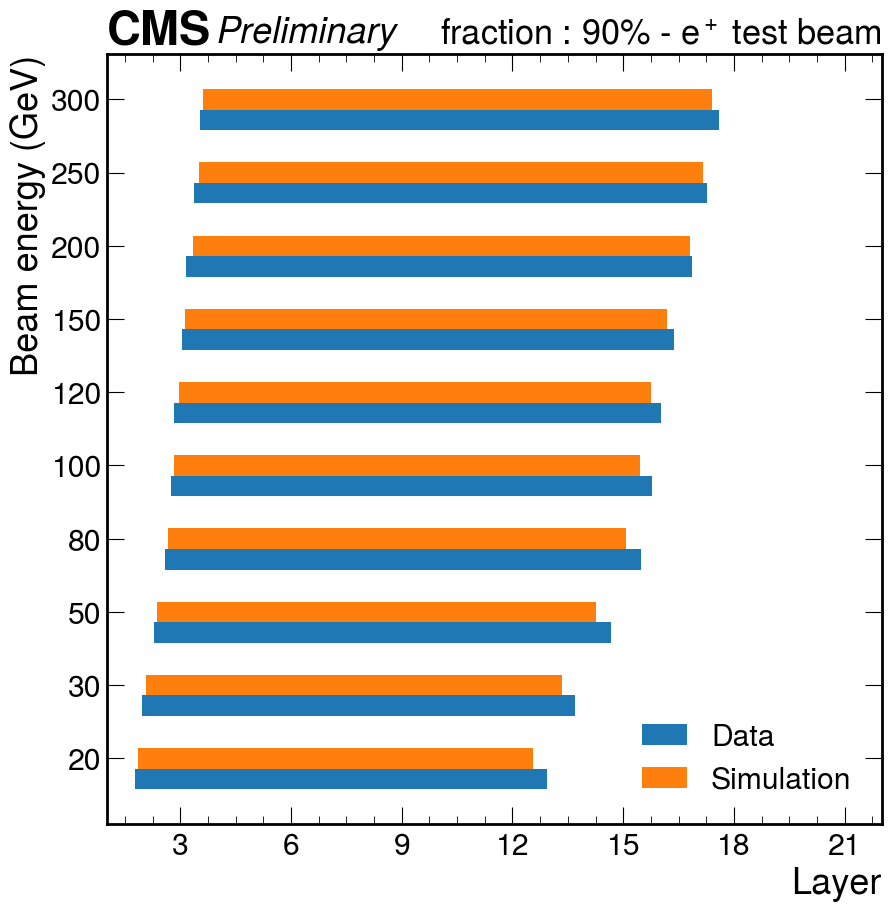

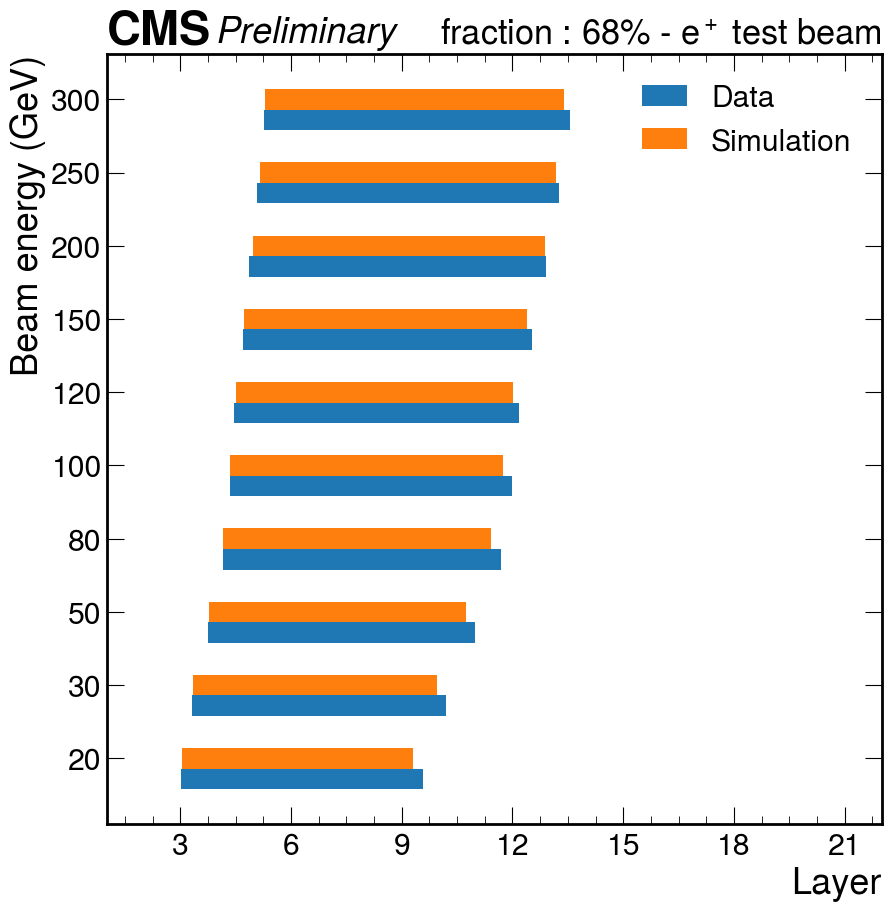

In [23]:
plotBarDouble(["data", "sim_proton_v46_patchMIP"], "0.9", beamEnergies)
plotBarDouble(["data", "sim_proton_v46_patchMIP"], "0.68", beamEnergies)